In [1]:
#Model development for Trawling4PACE
#Authors: HS, VA, FB, PP
#History: 1/29/26
#Goals: Run Random forest and boosted regression tree models for predicting silver hake abundance

In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer

In [2]:
# LOAD DATA
# ---------------------------------------------------
os.chdir('/home/jovyan/2026-proj-Trawling4PACE/data')

df = pd.read_csv(
    '/home/jovyan/2026-proj-Trawling4PACE/contributor_folders/leandro/correlation_data.csv'
)

In [3]:
# FEATURE ENGINEERING (DATE)
# ---------------------------------------------------
df['BEGIN_GMT_TOWDATE'] = pd.to_datetime(df['BEGIN_GMT_TOWDATE'])

df['month'] = df['BEGIN_GMT_TOWDATE'].dt.month
df['day']   = df['BEGIN_GMT_TOWDATE'].dt.day
df['year']  = df['BEGIN_GMT_TOWDATE'].dt.year
df['doy']   = df['BEGIN_GMT_TOWDATE'].dt.dayofyear

In [4]:
# CLEAN DATA
# ---------------------------------------------------
# Drop column that is entirely NaN + original datetime
df = df.drop(['glorys_thetao_bottom', 'BEGIN_GMT_TOWDATE'], axis=1)

In [5]:
# ---------------------------------------------------
# REMOVE NaN TARGETS (CRITICAL)
# ---------------------------------------------------
df = df.dropna(subset=['EXPCATCHNUM_log'])

In [6]:
# DEFINE FEATURES & TARGET
# ---------------------------------------------------
y = df['EXPCATCHNUM_log']

X = df[
    [
        'DECDEG_ENDLAT', 'DECDEG_ENDLON',
        'curl_stress_curl', 'fsle_fsle_max',
        'glorys_mlotst_surface', 'glorys_thetao_surface',
        'BOTTEMP', 'BOTSALIN',
        'SURFSALIN', 'SURFTEMP',
        'doy', 'year'
    ]
]

In [7]:
# TRAIN / TEST SPLIT
# ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
# KNN IMPUTATION (FIT ON TRAIN ONLY)
# ---------------------------------------------------
imputer = KNNImputer(
    n_neighbors=5,
    weights='distance'
)

X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

In [9]:
# HYPERPARAMETER GRID
# ---------------------------------------------------
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2', 0.8],
    'max_depth': [10, 20, 30, None]
}

rf = RandomForestRegressor(
    random_state=0,
    oob_score=True,
    bootstrap=True
)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# FIT GRID SEARCH
# ---------------------------------------------------
grid_search.fit(X_train_imputed, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV neg-MSE:", grid_search.best_score_)

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Best CV neg-MSE: -0.6746320206261194


In [10]:
#n_estimators == # of decision trees 
#oob_score == out of bag estimate of models general error
#random_state is for reproducibility

# FINAL MODEL
# ---------------------------------------------------
best_rf = RandomForestRegressor(
    **grid_search.best_params_,
    random_state=0,
    bootstrap=True,
    oob_score=True
)
best_rf.fit(X_train_imputed, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [11]:
# EVALUATION
# ---------------------------------------------------
print(f"Out-of-Bag Score: {best_rf.oob_score_}")

Out-of-Bag Score: 0.0063020652476901695


In [12]:
#Prediction
predictions = best_rf.predict(X_test_imputed)

In [13]:
#print R2 & MSE
mse = mean_squared_error(y_test, predictions)
r2  = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.6682831437072531
R-squared: 0.001543850042516559


In [14]:
importances = best_rf.feature_importances_

feature_imp_df = (
    pd.DataFrame({
        'Feature': X_train.columns,
        'Gini Importance': importances
    })
    .sort_values('Gini Importance', ascending=False)
)

print(feature_imp_df)

                  Feature  Gini Importance
0           DECDEG_ENDLAT         0.154069
1           DECDEG_ENDLON         0.134018
5   glorys_thetao_surface         0.097586
4   glorys_mlotst_surface         0.092542
6                 BOTTEMP         0.080448
3           fsle_fsle_max         0.078927
7                BOTSALIN         0.071830
8               SURFSALIN         0.071605
10                    doy         0.069815
2        curl_stress_curl         0.064763
9                SURFTEMP         0.064037
11                   year         0.020360


/tmp/ipykernel_116/2496803616.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


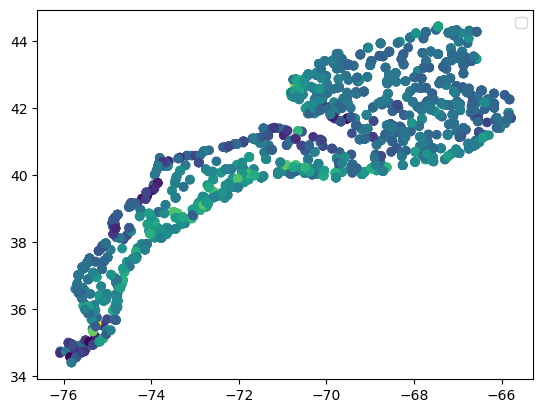

In [15]:
plt.scatter(X_test.DECDEG_ENDLON, X_test.DECDEG_ENDLAT, c=predictions) 
plt.legend()

In [ ]:
#!pip install shap

In [16]:
#BOOSTED REGRESSION TREE 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [17]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 8, 10],
    'reg_alpha': [0.0, 0.01, 0.05, 0.1],
    'reg_lambda': [0.1, 1, 2]
}

In [18]:
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_imputed, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV neg-MSE:", grid_search.best_score_)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 2}
Best CV neg-MSE: -0.661531699237633


In [19]:
xgb_reg = xgb.XGBRegressor(
    **grid_search.best_params_,
    objective='reg:squarederror',
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

xgb_reg.fit(X_train_imputed, y_train)

print("Model training complete.")

Model training complete.


In [20]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

predictions_brt = xgb_reg.predict(X_test_imputed)

rmse = np.sqrt(mean_squared_error(y_test, predictions_brt))
r2 = r2_score(y_test, predictions_brt)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")


Test RMSE: 0.8085
Test R²: 0.0233


Plotting feature importance...


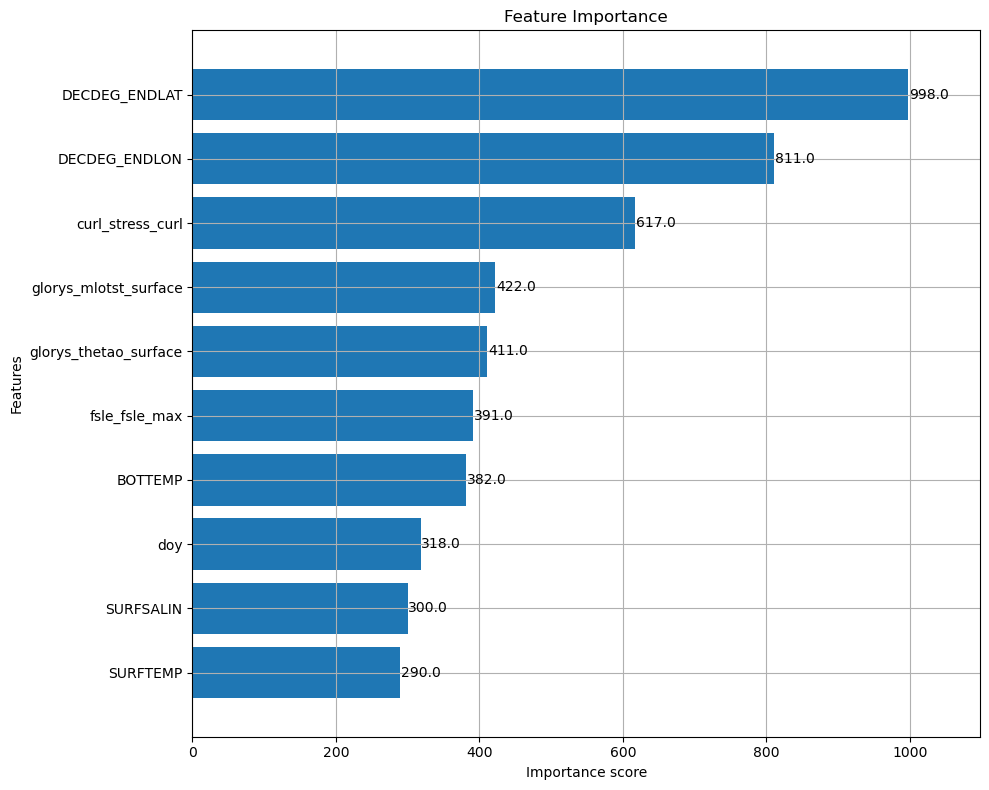

In [24]:
print("Plotting feature importance...")
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_reg, ax=ax, max_num_features=10, height=0.8, title="Feature Importance")
plt.tight_layout()
plt.show()

Text(0.5, 0.95, 'Partial Dependence plots for RF')

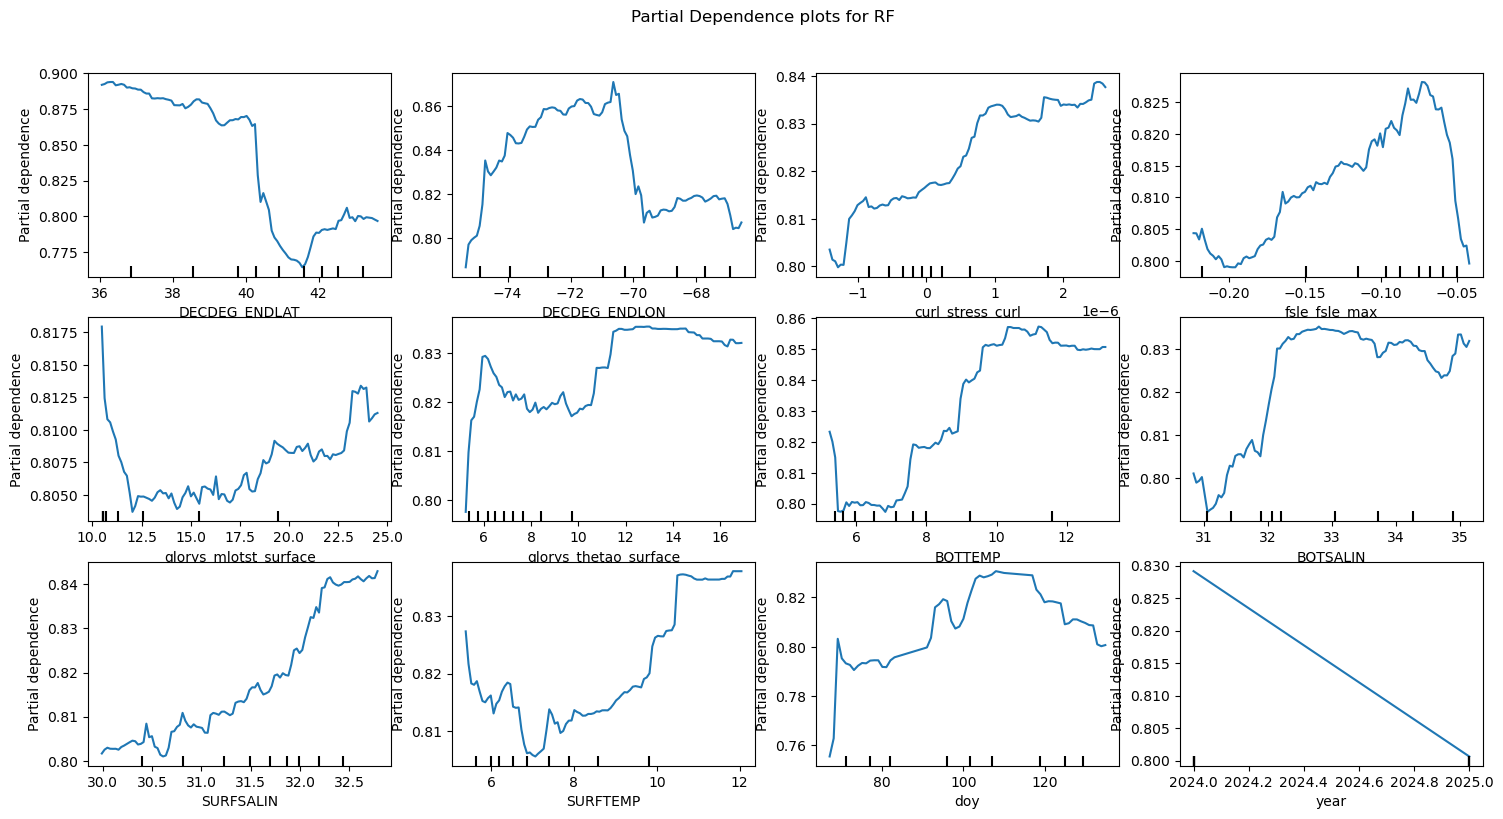

In [37]:
#RANDOM FOREST 
from sklearn.inspection import PartialDependenceDisplay
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 9))
# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten()

# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    try: 
        PartialDependenceDisplay.from_estimator(
                            estimator=best_rf,
                            X=X_train_imputed,
                            features=[X_train_imputed.columns[i]],
                            target='EXPCATCHNUM',  
                            ax=ax
                        )
        #ax.set_title(f"{species}")
        ax.set_ylabel("Partial Dependence (log CPUE scale)")
    except IndexError:
        ax.remove()

fig.suptitle('Partial Dependence plots for RF',y=0.95)

Text(0.5, 0.95, 'Partial Dependence plots for BRT')

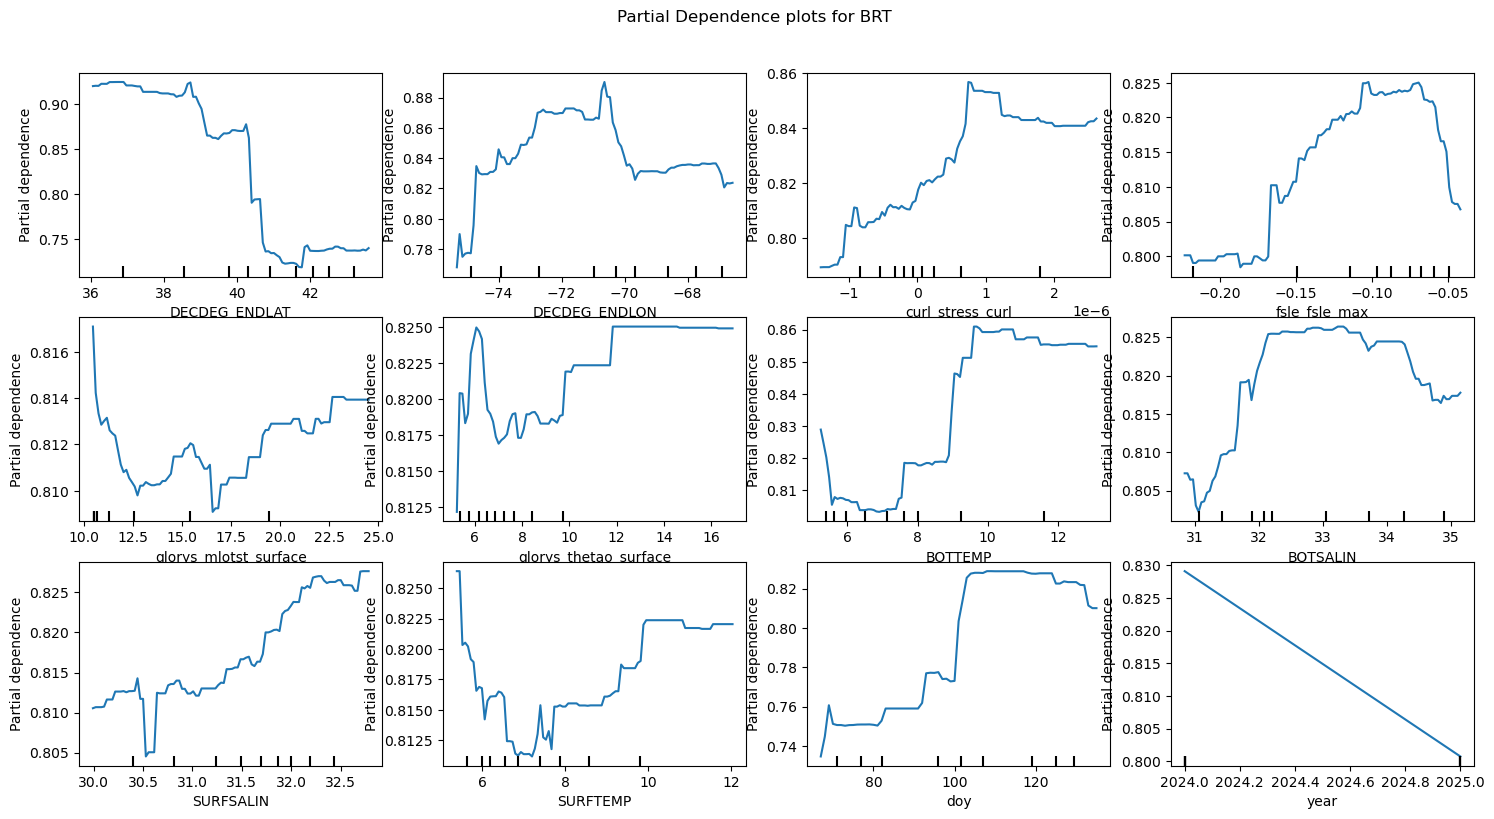

In [38]:
#BOOSTED REGRESSION TREE
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 9))
# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten()

# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    try: 
        PartialDependenceDisplay.from_estimator(
                            estimator=xgb_reg,
                            X=X_train_imputed,
                            features=[X_train_imputed.columns[i]],
                            target='EXPCATCHNUM',  
                            ax=ax
                        )
        #ax.set_title(f"{species}")
        ax.set_ylabel("Partial Dependence (log CPUE scale)")
    except IndexError:
        ax.remove()

fig.suptitle('Partial Dependence plots for BRT',y=.95)

Text(0.5, 0.7, 'Silver Hake Abundance')

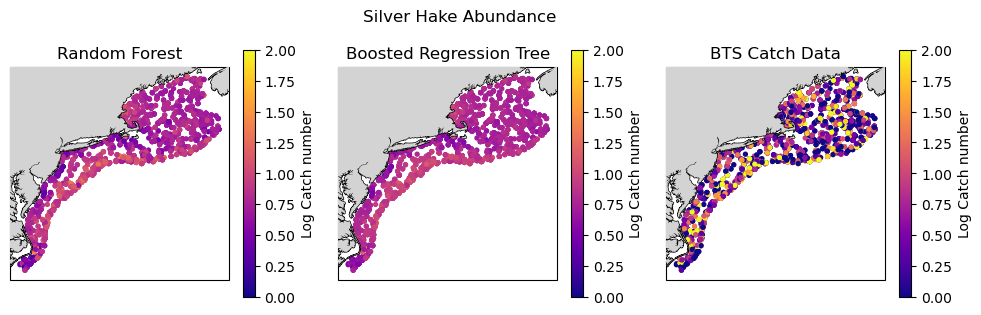

In [29]:
#VISUALIZE RESULTS
import cartopy

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, subplot_kw={'projection': cartopy.crs.PlateCarree()}, figsize=(12, 8))
im=ax1.scatter(df.loc[X_test_imputed.index.tolist()].DECDEG_ENDLON, df.loc[X_test_imputed.index.tolist()].DECDEG_ENDLAT, c=predictions,vmin=0,vmax=2,cmap='plasma',s=8)
ax1.set_title('Random Forest')
fig.colorbar(im, ax=ax1,shrink=0.4,label='Log Catch number')
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=1)
ax1.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')

im1=ax2.scatter(df.loc[X_test_imputed.index.tolist()].DECDEG_ENDLON, df.loc[X_test_imputed.index.tolist()].DECDEG_ENDLAT, c=predictions_brt,vmin=0,vmax=2,cmap='plasma',s=8)
ax2.set_title('Boosted Regression Tree')
fig.colorbar(im1, ax=ax2,shrink=0.4,label='Log Catch number')
ax2.add_feature(cartopy.feature.COASTLINE, linewidth=1)
ax2.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')

im2=ax3.scatter(df.loc[X_test_imputed.index.tolist()].DECDEG_ENDLON, df.loc[X_test_imputed.index.tolist()].DECDEG_ENDLAT, c=df.loc[y_test.index.tolist()].EXPCATCHNUM_log,cmap='plasma',vmin=0,vmax=2,s=8)
ax3.set_title('BTS Catch Data')
fig.colorbar(im2, ax=ax3,shrink=0.4,label='Log Catch number')
ax3.add_feature(cartopy.feature.COASTLINE, linewidth=1)
ax3.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')
fig.suptitle('Silver Hake Abundance', y=0.7)

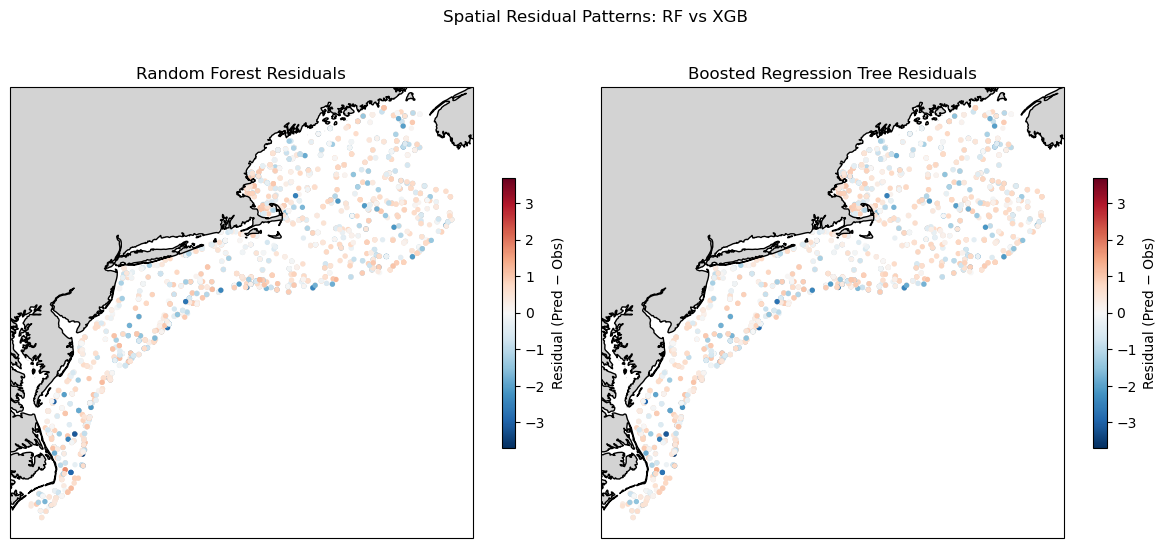

In [54]:
#compute residuals
import numpy as np

idx = X_test_imputed.index

obs = df.loc[y_test.index, 'EXPCATCHNUM_log']

rf_resid  = predictions      - obs
xgb_resid = predictions_brt  - obs

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Index alignment
idx = X_test_imputed.index

# Coordinates
lons = df.loc[idx, 'DECDEG_ENDLON']
lats = df.loc[idx, 'DECDEG_ENDLAT']

# Observations
obs = df.loc[y_test.index, 'EXPCATCHNUM_log']

# Residuals
rf_resid  = predictions      - obs
xgb_resid = predictions_brt  - obs

# Symmetric color scale around zero
abs_max = np.nanmax(np.abs(np.concatenate([rf_resid, xgb_resid])))

fig, (ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# --- Random Forest residuals ---
sc1 = ax1.scatter(
    lons, lats,
    c=rf_resid,
    cmap='RdBu_r',
    vmin=-abs_max, vmax=abs_max,
    s=8,
    transform=ccrs.PlateCarree()
)
ax1.set_title('Random Forest Residuals')
ax1.add_feature(cfeature.COASTLINE, linewidth=1)
ax1.add_feature(cfeature.LAND, facecolor='lightgrey')
plt.colorbar(sc1, ax=ax1, shrink=0.5, label='Residual (Pred − Obs)')

# --- XGBoost residuals ---
sc2 = ax2.scatter(
    lons, lats,
    c=xgb_resid,
    cmap='RdBu_r',
    vmin=-abs_max, vmax=abs_max,
    s=8,
    transform=ccrs.PlateCarree()
)
ax2.set_title('Boosted Regression Tree Residuals')
ax2.add_feature(cfeature.COASTLINE, linewidth=1)
ax2.add_feature(cfeature.LAND, facecolor='lightgrey')
plt.colorbar(sc2, ax=ax2, shrink=0.5, label='Residual (Pred − Obs)')

fig.suptitle('Spatial Residual Patterns: RF vs XGB', y=0.98)
plt.tight_layout()
plt.show()


Text(1, 1.3, 'RMSE: 0.079')

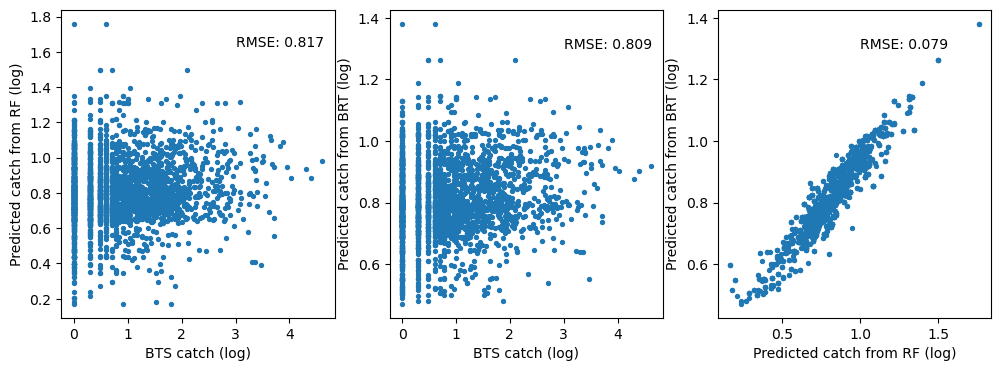

In [47]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4)) 
ax1.scatter(df.loc[y_test.index.tolist()].EXPCATCHNUM_log, predictions,s=8)
ax1.set_xlabel('BTS catch (log)')
ax1.set_ylabel('Predicted catch from RF (log)')

ax2.scatter(df.loc[y_test.index.tolist()].EXPCATCHNUM_log, predictions_brt,s=8)
ax2.set_xlabel('BTS catch (log)')
ax2.set_ylabel('Predicted catch from BRT (log)')

ax3.scatter(predictions, predictions_brt,s=8)
ax3.set_xlabel('Predicted catch from RF (log)')
ax3.set_ylabel('Predicted catch from BRT (log)')


ax1.text(3,1.63, f'RMSE: {np.round(np.sqrt(np.mean((df.loc[y_test.index.tolist()].EXPCATCHNUM_log - predictions)**2)),3)}')
ax2.text(3,1.30, f'RMSE: {np.round(np.sqrt(np.mean((df.loc[y_test.index.tolist()].EXPCATCHNUM_log - predictions_brt)**2)),3)}')
ax3.text(1,1.30, f'RMSE: {np.round(np.sqrt(np.mean((predictions - predictions_brt)**2)),3)}')

Text(0.5, 1.0, 'RF predictions v BRT predictions')

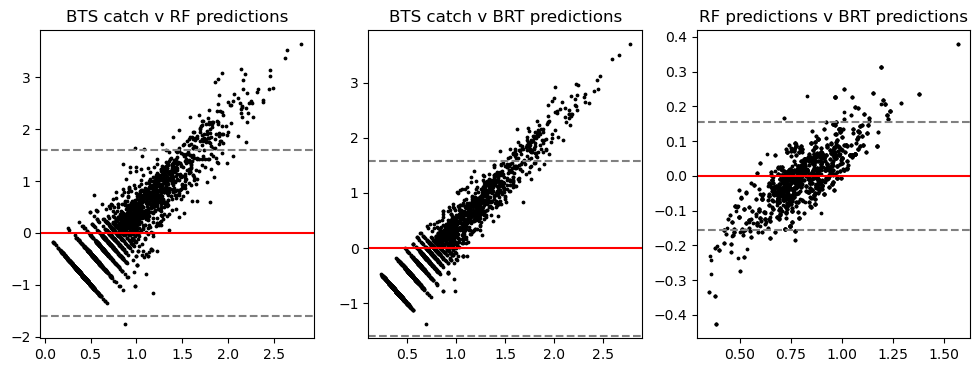

In [42]:
#Band Altman Plot
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4)) 
x=df.loc[y_test.index.tolist()].EXPCATCHNUM_log
y=predictions
differences= x-y
mean= (x+y)/2
ax1.scatter(mean, differences,s=3,c='black')
ax1.axhline(np.mean(differences), color='red', linestyle='-', label='Mean Diff')
ax1.axhline(np.mean(differences) + 1.96*np.std(differences), color='gray', linestyle='--', label='Limits of agreement')
ax1.axhline(np.mean(differences) - 1.96*np.std(differences), color='gray', linestyle='--')
ax1.set_title('BTS catch v RF predictions')
#ax1.text(0.03, 0.12, f'N={len(x)}\nMAPE={((abs(x - y) / abs(x)).mean()*100).round(3)}', horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes, fontsize=9)

x=df.loc[y_test.index.tolist()].EXPCATCHNUM_log
y=predictions_brt
differences= x-y
mean= (x+y)/2
ax2.scatter(mean, differences,s=3,c='black')
ax2.axhline(np.mean(differences), color='red', linestyle='-', label='Mean Diff')
ax2.axhline(np.mean(differences) + 1.96*np.std(differences), color='gray', linestyle='--', label='Limits of agreement')
ax2.axhline(np.mean(differences) - 1.96*np.std(differences), color='gray', linestyle='--')
ax2.set_title('BTS catch v BRT predictions')

x=predictions
y=predictions_brt
differences= x-y
mean= (x+y)/2
ax3.scatter(mean, differences,s=3,c='black')
ax3.axhline(np.mean(differences), color='red', linestyle='-', label='Mean Diff')
ax3.axhline(np.mean(differences) + 1.96*np.std(differences), color='gray', linestyle='--', label='Limits of agreement')
ax3.axhline(np.mean(differences) - 1.96*np.std(differences), color='gray', linestyle='--')
ax3.set_title('RF predictions v BRT predictions')

In [ ]:
#NEXT STEPS:
# victorias going statistically compare models 
# visualization of results between models 
    # look at abundance comparisons 
# SHAP analysis (and plots) 
# statistically compare performance of models output 
# are there other metrics to look at model performance?? 
# timeseries plot of predictions 
# fishing hotspots from abundance???? (we may not have enough data to look at this) 
# limitations 